# Permutation Test Example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", palette="muted", color_codes=True)

from mltools.resampling import PermutationTest

## Monte Carlo Permutation Test

This is a Python port (with modifications) of [Thomas Leeper's R permutation test example](http://thomasleeper.com/Rcourse/Tutorials/permutationtests.html).

We generate a sample $X$ of size $100$ from the $\mathrm{Bernoulli}(1/2)$ distribution and another sample $Y$ of size $150$ from the $\mathrm{Bernoulli}(1/2)$ offset by some $\mathrm{Normal}(1, 3^2)$ noise.

In [2]:
np.random.seed(0)
x = np.random.binomial(n=1, p=0.5, size=100)
y = np.random.binomial(n=1, p=0.5, size=150) + np.random.normal(loc=1, scale=3, size=150)

We visualize the observed samples $X$ and $Y$ using a histogram.

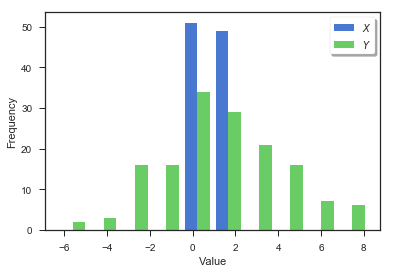

In [3]:
plt.figure()
plt.hist((x, y), label=("$X$", "$Y$"))
plt.legend(loc="best", frameon=True, shadow=True)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()
plt.close()

Pretending we didn't know the distributions of $X$ and $Y$, we wish to test whether these data come from distributions with different means.
To test this hypothesis, our null hypothesis $H_0$ is that the underlying distributions *do* have the same mean.

A natural test statistic for this scenario is the absolute difference in means between two samples.
If $H_0$ were true, then this difference would be close to $0$.
If $H_0$ were false, then this difference would be significantly positive.

In [4]:
def stat(x, y):
    return np.abs(np.mean(x) - np.mean(y))

Since we know the true distributions of $X$ and $Y$, we expect the observed difference in means between $X$ and $Y$ to be close to $1$.

In [5]:
print(stat(x, y))

0.829291872847185


Now we perform a permutation test at the default $\alpha = 0.05$ significance level to determine whether this high of a difference could be attributed to chance alone (we expect it couldn't).

In [6]:
%%time
pt = PermutationTest(x, y, stat=stat, n_perm=15000, seed=0)

CPU times: user 596 ms, sys: 6.48 ms, total: 602 ms
Wall time: 600 ms


Having performed the test, we can now report a $p$-value.

In [7]:
p_value = pt.p_value(tail="right")
print(f"p-value: {p_value:.4f}")

p-value: 0.0057


This low $p$-value allows us to reject $H_0$ at the $\alpha = 0.05$ significance level, suggesting that the observed absolute difference in means is extreme relative to the empirical distribution of the mean differences of the permuted samples.

### Visualizing the Permutation Test

To visualize the test, we can plot the histogram of the empirical distribution of mean differences obtained for the permutated samples and compare it to the true mean difference.

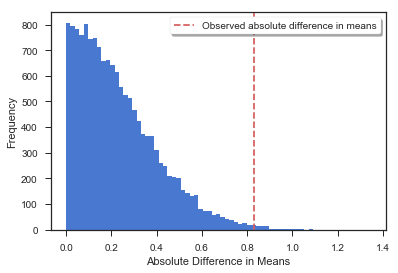

In [8]:
plt.figure()

plt.hist(pt.dist, bins="auto")
plt.axvline(pt.observed, c="r", ls="--", label="Observed absolute difference in means")
plt.legend(loc="best", frameon=True, shadow=True)
plt.xlabel("Absolute Difference in Means")
plt.ylabel("Frequency")
plt.show()
plt.close()